# Document Setup

- Project ID: EMB_ex17
- Researchers: DK
- Current Version: v1.0

See associated protocol for more details.

In [1]:
# Stdlib
import sys
import os
from datetime import datetime
import random
from IPython.display import display, Latex

# Scientific computing
import numpy as np
from node2vec import Node2Vec as N2V

# Network science
import networkx as nx

# Data handling and vis
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.lines import Line2D

# Project source
sys.path.append("../../src/")
import synthetic
import utils

# Miscellaneous
from tqdm.auto import tqdm

In [2]:
metadata = {
    "PROJECT_ID": "EMB_ex17-R",
    "RESEARCHERS": "DK",
    "CURRENT_VERSION": "v1.0",
    "DATE": datetime.today().strftime("%Y%m%d")
}
TAG = "{PROJECT_ID}{CURRENT_VERSION}_{RESEARCHERS}_{DATE}".format(**metadata)

# Experiment

## Preface

**Goal**

Explore fundamental differences in link prediction and multiplex reconstruction setting on uncorrelated ring topologies.

**Procedure**

1. Generate a ring network, $G$.
2. Create a deepcopy of $G$, $H$, and shuffle the node labels of $H$.
3. Aggregate $G, H$; call it $A$
4. Observe some partial observations from $A$; call them $\theta_G, \theta_H$
5. Calculate the remnants; $R_G = A - \theta_H, R_H = A - \theta_G$
6. Embed $R_G, R_H$; call them $E_G, E_H$
7. Select some edge, $e = (i,j) \in A$
8. Calculate $d_G = d_{E_G}(i, j), d_H = d_{E_H}(i, j)$
9. Repeat (7), (8) for all edges $e \in A$
10. Examine resultant distribution of $d$

## Prerequisite code

In [3]:
def generate_ring_duplex(number_of_nodes):
    """
    Generate a duplex of rings with one layer having shuffled node labels of the other.
    """
    # Create one layer, a ring network
    G = nx.cycle_graph(number_of_nodes)

    # Independent shallow copy the layer
    # * Note that node and edge attributes may have correlations - for this experiment, does not matter but it may in the future
    H = G.copy()

    # Shuffle H's nodes
    new_labels = list(H.nodes())
    random.shuffle(new_labels)  # ^ Why is there such a mix of in-place functions and not :,(
    relabeling_mapping = {node: new_labels[node] for node in range(H.number_of_nodes())}
    H = nx.relabel_nodes(H, relabeling_mapping)

    # ? Do I need to remove any still existing overlap? That would cause disconnectedness necessarily (if overlap is present)

    return G, H

In [4]:
def get_representation(G, params):
    """
    Embed a monoplex with node2vec. Wrapper from @Minsuk Kim.
    """
    # Unpack parameters
    dimensions, walk_length, num_walks, workers,\
    window, min_count, batch_words = params

    # Create node2vec model
    n2v = N2V(G,
        dimensions = dimensions,
        walk_length = walk_length,
        num_walks = num_walks,
        workers = workers,
        quiet = True,
    )

    # Embed topology under specified n2v model
    embedding = n2v.fit(window = window,
        min_count = min_count,
        batch_words = batch_words,
    )

    # Format resultant vectors
    # ! NOTE: Currently broken for real networks
    # ! >>> Broken >>>
    # * Output format: Array with row [i] corresponding to embedded vector of node i
    # representation = np.array([
    #     embedding.wv['%d' % i]
    #     for i in range(G.number_of_nodes())
    # ])
    # ! <<< Broken <<<

    # ! >>> Hot fix >>>
    embedding = embedding.wv
    index_ = embedding.index_to_key
    vectors_ = embedding.vectors
    representation = {int(index_[idx]): vectors_[idx] for idx in range(G.number_of_nodes())}
    # ! <<< Hot fix <<<

    return representation

In [5]:
def calculate_distances(edge, E_G, E_H):
    # Retrieve nodes incident to edge
    i, j = edge

    # Calculate distance between incident nodes in both embeddings
    d_G = np.linalg.norm(E_G[i] - E_G[j])
    d_H = np.linalg.norm(E_H[i] - E_H[j])

    return d_G, d_H

## Workflow

In [6]:
# * Experiment Parameters
# >>> Network topology <<<
N = 100  # size of rings
theta = 0.5  # relative size of remnants

# >>> Node2Vec embedding <<<
dimensions = 100  # euclidean dimension to embedd
num_walks = 100  # number of walks per node
workers = 10  # for cpu parallel work
window = 10  # maximum distance between the current and predicted word within a sentence.
min_count = 1  # ignores all words with total frequency lower than this
batch_words = 4  # [unsure]


# >>> Other <<<
repeat = 100  # number of simulations

In [7]:
# * Steps (1), (2) - Get desired duplex
D = utils.read_file("../../data/input/raw/duplex_system=london.edgelist")
G, H = utils.duplex_network(D, 1, 2)

### Sweep walk_length

In [8]:
delta_wl = 5
wl_start = 5
wl_end = 30
wls = np.arange(wl_start, wl_end + delta_wl, step=delta_wl)  # walk length
distances_sweep = {}

In [9]:
for wl in tqdm(wls):
    # * Steps (3) thru (5) - Observe a priori information and calculate remnants
    R_G, R_H, A = utils.partial_information(G, H, theta)

    # * Step (6) - Embed remnants
    params = [dimensions, wl, num_walks, workers, window, min_count, batch_words]
    E_G = get_representation(R_G, params)
    E_H = get_representation(R_H, params)

    # * Steps (7) thru (9) - Calculate distances of nodes incident to edges in both embeddings
    distances = {}
    for edge in A.keys():
        d = calculate_distances(edge, E_G, E_H)
        distances[edge] = d

    distances_sweep[wl] = distances

100%|██████████| 6/6 [06:08<00:00, 61.47s/it]


## Analysis

### Processing and cleanup

In [10]:
filepath_df = f"../../results/dataframes/dataframe_{TAG}.csv"
filepath_df_melted = f"../../results/dataframes/dataframe-mellted_{TAG}.csv"

if os.path.exists(filepath_df) and os.path.exists(filepath_df_melted):
    df = pd.read_csv(filepath_df)
    df_melted = pd.read_csv(filepath_df_melted)
else:
    records = []
    for walk_length, distances in distances_sweep.items():
        for edge, d in distances.items():
            if edge not in A:
                edge = edge[::-1]

            record = {
                "walk_length": walk_length,
                "d_G": d[0],
                "d_H": d[1],
                "edge": edge,
                "ground_truth_aprx": 1 if ((edge[0] == edge[1]+1) or (edge[1] == edge[0]+1)) else 0,
                "classification": int(d[0] <= d[1]),
            }
            records.append(record)

    df = pd.DataFrame.from_records(records)
    df["correct"] = df["ground_truth_aprx"] == df["classification"]
    df["inverse"] = (1/df["d_G"]) / ((1/df["d_G"]) + (1/df["d_H"]))
    df["negexp"] = np.exp(-df["d_G"]) / (np.exp(-df["d_G"]) + np.exp(-df["d_H"]))

    df_melted = pd.melt(df, id_vars=["walk_length", "edge", "inverse", "negexp", "correct", "ground_truth_aprx"], value_vars=["d_G", "d_H"], var_name="layer", value_name="distance")
    df_melted = pd.melt(df_melted, id_vars=["walk_length", "edge", "correct", "layer", "distance", "ground_truth_aprx"], value_vars=["inverse", "negexp"], var_name="likelihood_metric", value_name="score")

    df.to_csv(filepath_df)
    df_melted.to_csv(filepath_df_melted)

### Visualizations

#### Distance

<Figure size 640x480 with 0 Axes>

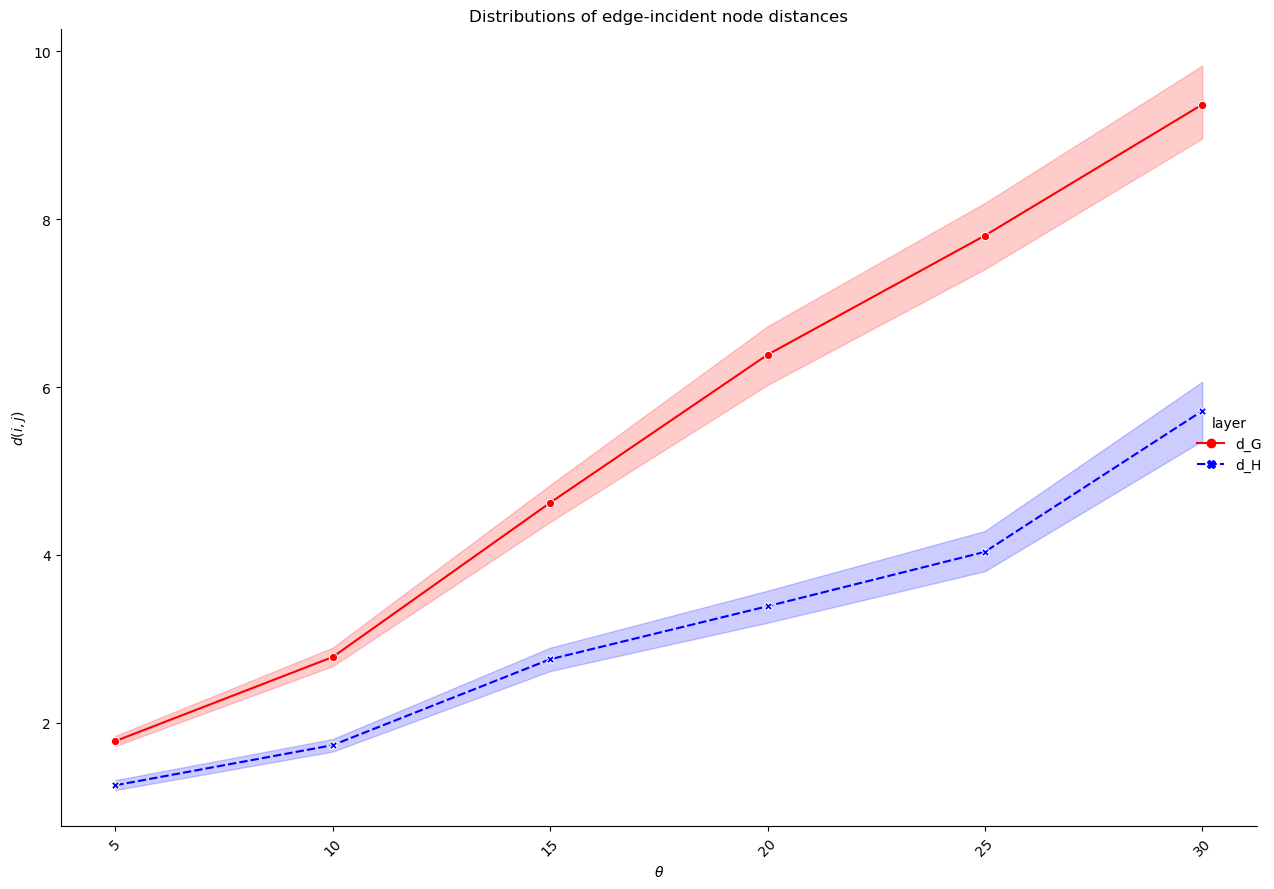

In [18]:
plt.figure()

sns.relplot(
    data=df_melted, kind="line",
    x="walk_length", y="distance",
    hue="layer", palette=["red", "blue"],
    style="layer",
    markers=True,
    height=9, aspect=12/9
)

plt.xlabel("$\\theta$")
plt.ylabel("$d(i,j)$")
plt.title("Distributions of edge-incident node distances")

plt.xticks(wls, rotation=45)

plt.tight_layout()

plt.savefig(f"../../results/plots/line_distances_{TAG}.png", facecolor="white", transparent=False)

<Figure size 640x480 with 0 Axes>

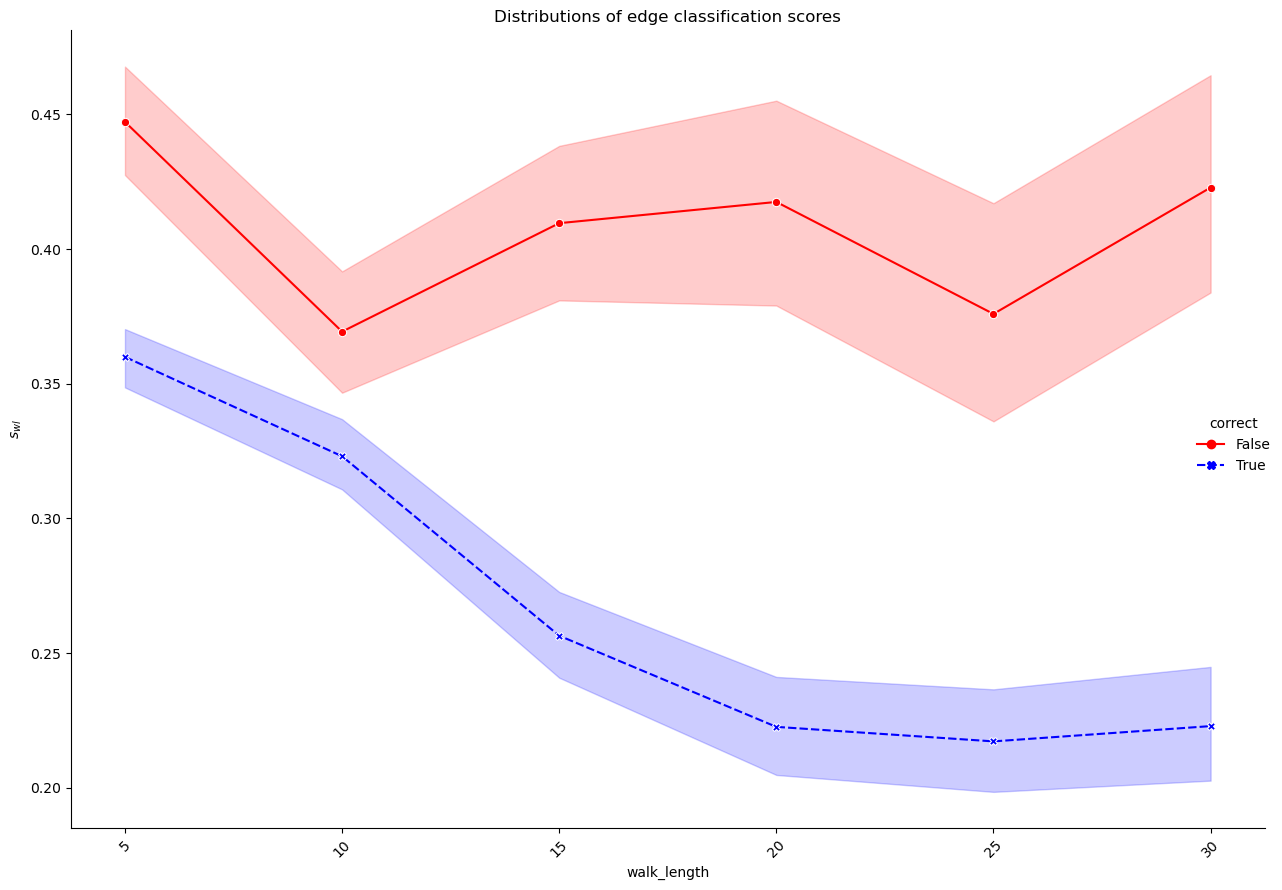

In [19]:
plt.figure()

sns.relplot(
    data=df_melted, kind="line",
    x="walk_length", y="score",
    hue="correct", palette=["red", "blue"],
    style="correct",
    markers=True,
    height=9, aspect=12/9
)

plt.xlabel("walk_length")
plt.ylabel("$s_{wl}$")
plt.title("Distributions of edge classification scores")

plt.xticks(wls, rotation=45)

plt.tight_layout()

plt.savefig(f"../../results/plots/line_scores_{TAG}.png", facecolor="white", transparent=False)

#### Accuracy

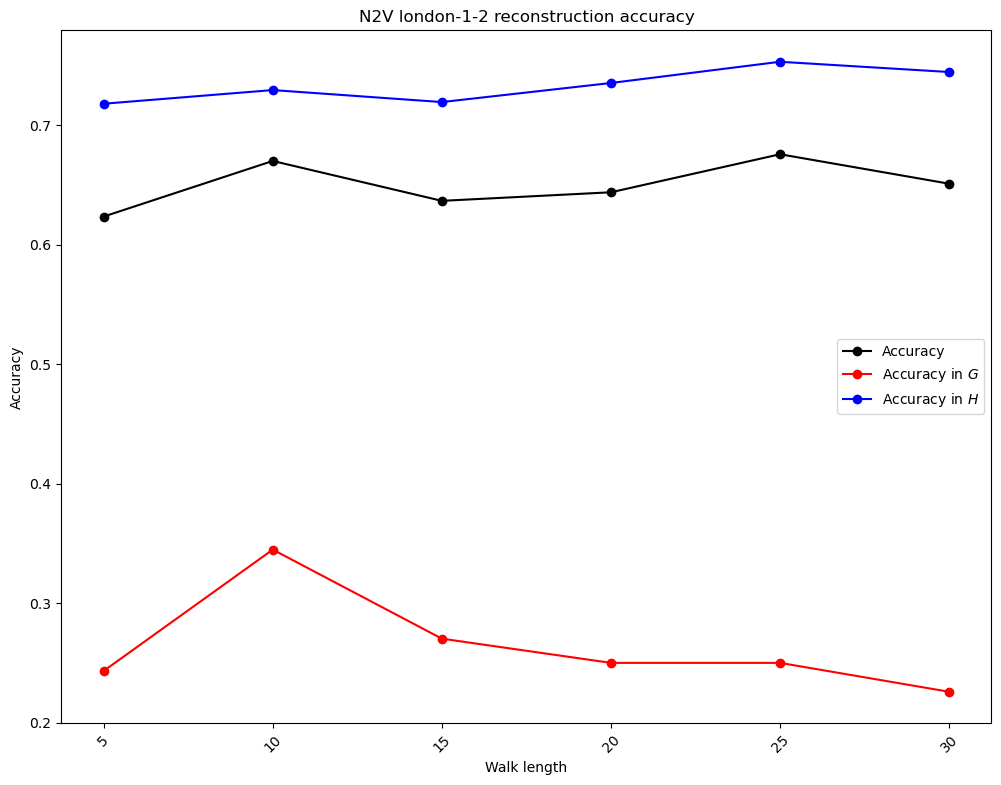

In [20]:
plt.figure(figsize=(12,9))

df.groupby("walk_length")["correct"].mean().plot(marker="o", color="black", label="Accuracy")
df.loc[df["classification"]==1].groupby("walk_length")["correct"].mean().plot(marker="o", color="red", label="Accuracy in $G$")
df.loc[df["classification"]==0].groupby("walk_length")["correct"].mean().plot(marker="o", color="blue", label="Accuracy in $H$")

plt.legend()

plt.xticks(wls, rotation=45)
#plt.yticks(np.arange(0.5, 1.05, 0.05))

plt.xlabel("Walk length")
plt.ylabel("Accuracy")
plt.title("N2V london-1-2 reconstruction accuracy")

plt.savefig(f"../../results/plots/line_accuracy_{TAG}.png", facecolor="white", transparent=False)